In [ ]:
import os
import numpy
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time
from collections import Counter
from torch.autograd import Variable
import skimage.io
from matplotlib import cm
from sklearn.manifold import TSNE
#from torchvision import transforms
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import random
import sys
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [ ]:
split_no = 4
X_train = np.r_[np.load('/content/drive/MyDrive/MLSP/nn_novelty/X_train_split'+str(split_no)+'.npy'), 
                np.load('/content/drive/MyDrive/MLSP/nn_novelty/X_train_split'+str(split_no-1)+'.npy'),
                np.load('/content/drive/MyDrive/MLSP/nn_novelty/X_train_split'+str(split_no-2)+'.npy'),
                np.load('/content/drive/MyDrive/MLSP/nn_novelty/X_train_split'+str(split_no-3)+'.npy'),
                np.load('/content/drive/MyDrive/MLSP/nn_novelty/X_train_split'+str(split_no-4)+'.npy')]
y_train = np.r_[np.load('/content/drive/MyDrive/MLSP/nn_novelty/y_train_split'+str(split_no)+'.npy'),
                np.load('/content/drive/MyDrive/MLSP/nn_novelty/y_train_split'+str(split_no-1)+'.npy'),
                np.load('/content/drive/MyDrive/MLSP/nn_novelty/y_train_split'+str(split_no-2)+'.npy'),
                np.load('/content/drive/MyDrive/MLSP/nn_novelty/y_train_split'+str(split_no-3)+'.npy'),
                np.load('/content/drive/MyDrive/MLSP/nn_novelty/y_train_split'+str(split_no-4)+'.npy')]
print(X_train.shape, y_train.shape)
print('Original dataset shape %s' % Counter(y_train))
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('SMOTE dataset shape %s' % Counter(y_train))
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)

(935640, 117) (935640,)
Original dataset shape Counter({0.0: 849252, 1.0: 86388})
SMOTE dataset shape Counter({1.0: 849252, 0.0: 849252})


In [ ]:
'''X_val_all = np.load('/content/drive/MyDrive/MLSP/nn_novelty/X_val_split'+str(split_no)+'.npy', allow_pickle=True)
y_val_all = np.load('/content/drive/MyDrive/MLSP/nn_novelty/y_val_split'+str(split_no)+'.npy', allow_pickle=True)
X_val_all.shape, y_val_all.shape'''

"X_val_all = np.load('/content/drive/MyDrive/MLSP/nn_novelty/X_val_split'+str(split_no)+'.npy', allow_pickle=True)\ny_val_all = np.load('/content/drive/MyDrive/MLSP/nn_novelty/y_val_split'+str(split_no)+'.npy', allow_pickle=True)\nX_val_all.shape, y_val_all.shape"

In [ ]:
n_h1 = 800
n_h2 = 500
#n_h3=20
class Model(nn.Module):
    def __init__(self, in_features=117, h1=n_h1, h2=n_h2, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        #self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = F.softmax(self.out(x))
        return x

    '''def embedding(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x'''

In [ ]:
X_train = torch.FloatTensor(X_train).cuda()
y_train = torch.LongTensor(y_train).cuda()

In [ ]:
train = torch.utils.data.TensorDataset(X_train, y_train)
#test = torch.utils.data.TensorDataset(X_test, y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = 200, shuffle = True)
#test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [ ]:
# Instantiate the Model class using parameter defaults:
torch.manual_seed(42)
model = Model()
model = model.cuda()
next(model.parameters()).is_cuda

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
losses = []
losses_test = []
for ep in range(epochs):
    ep+=1
    for i, (X, labels) in enumerate(train_loader):
        X = X.cuda()
        labels = labels.cuda()
        X = Variable(X)
        labels = Variable(labels)
        y_pred = model.forward(X)
        loss = criterion(y_pred, labels)
        losses.append(loss)

        # a neat trick to save screen space:
        if i%20 == 1:
            print(f'epoch: {ep:2} iter: {i:2} loss: {loss.item():10.8f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

epoch:  1 iter:  1 loss: 0.69569498
epoch:  1 iter: 21 loss: 0.65933019
epoch:  1 iter: 41 loss: 0.65136302
epoch:  1 iter: 61 loss: 0.65942657
epoch:  1 iter: 81 loss: 0.69036555
epoch:  1 iter: 101 loss: 0.61717534
epoch:  1 iter: 121 loss: 0.65336561
epoch:  1 iter: 141 loss: 0.64828461
epoch:  1 iter: 161 loss: 0.65575373
epoch:  1 iter: 181 loss: 0.62482542
epoch:  1 iter: 201 loss: 0.61055529
epoch:  1 iter: 221 loss: 0.62098688
epoch:  1 iter: 241 loss: 0.59262228
epoch:  1 iter: 261 loss: 0.59577179
epoch:  1 iter: 281 loss: 0.61618221
epoch:  1 iter: 301 loss: 0.63562703
epoch:  1 iter: 321 loss: 0.62570876
epoch:  1 iter: 341 loss: 0.61684507
epoch:  1 iter: 361 loss: 0.55866671
epoch:  1 iter: 381 loss: 0.59433210
epoch:  1 iter: 401 loss: 0.55489749
epoch:  1 iter: 421 loss: 0.57167733
epoch:  1 iter: 441 loss: 0.55512613
epoch:  1 iter: 461 loss: 0.59616709
epoch:  1 iter: 481 loss: 0.56654364
epoch:  1 iter: 501 loss: 0.59986466
epoch:  1 iter: 521 loss: 0.57093465
epoch:

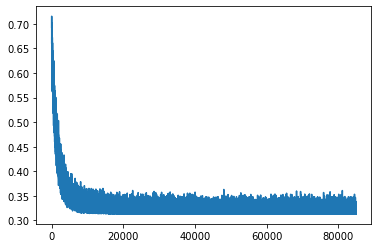

In [ ]:
plt.plot(losses)

In [ ]:
'''correct_count = 0
y_pred = []
with torch.no_grad():
  store_val_probs = []
  for i in range(y_val_all.shape[0]):
      X_val = X_val_all[i]
      y_val = y_val_all[i]
      X_val = scaler.transform(X_val)
      X_val = torch.FloatTensor(X_val).cuda()
      #y_val = torch.LongTensor(y_val).cuda()
      pred_prob_val = np.array(model.forward(X_val).cpu())
      #print(pred_prob_val.mean(axis=0).shape)
      #y_pred.append(pred_prob_val.argmax().item())
      store_val_probs.append(pred_prob_val.mean(axis=0)[1])
      predicted_class = int(np.argmax(pred_prob_val.mean(axis=0)))
      #print(f'pred label: {predicted_class}, true label: {int(y_val)}')
      if predicted_class==int(y_val):
          correct_count+=1
      else:
          #print('wrongly classified')
          pass
  val_accuracy = correct_count*100/int(y_val_all.shape[0])
  print(f'validation accuracy: {val_accuracy}')
  print(f'auc_roc score: {roc_auc_score(numpy.array(y_val_all).ravel(), numpy.array(store_val_probs).ravel())}')
  sys.stdout.flush()'''

"correct_count = 0\ny_pred = []\nwith torch.no_grad():\n  store_val_probs = []\n  for i in range(y_val_all.shape[0]):\n      X_val = X_val_all[i]\n      y_val = y_val_all[i]\n      X_val = scaler.transform(X_val)\n      X_val = torch.FloatTensor(X_val).cuda()\n      #y_val = torch.LongTensor(y_val).cuda()\n      pred_prob_val = np.array(model.forward(X_val).cpu())\n      #print(pred_prob_val.mean(axis=0).shape)\n      #y_pred.append(pred_prob_val.argmax().item())\n      store_val_probs.append(pred_prob_val.mean(axis=0)[1])\n      predicted_class = int(np.argmax(pred_prob_val.mean(axis=0)))\n      #print(f'pred label: {predicted_class}, true label: {int(y_val)}')\n      if predicted_class==int(y_val):\n          correct_count+=1\n      else:\n          #print('wrongly classified')\n          pass\n  val_accuracy = correct_count*100/int(y_val_all.shape[0])\n  print(f'validation accuracy: {val_accuracy}')\n  print(f'auc_roc score: {roc_auc_score(numpy.array(y_val_all).ravel(), numpy.array

In [ ]:
'''fpr, tpr, thresholds = metrics.roc_curve(y_val_all, np.array(store_val_probs).ravel())
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('fpr')
plt.ylabel('tpr')
np.save('roc_dnn'+str(split_no)+'.npy',np.array([fpr, tpr]))'''

"fpr, tpr, thresholds = metrics.roc_curve(y_val_all, np.array(store_val_probs).ravel())\nplt.plot(fpr, tpr)\nplt.plot([0, 1], [0, 1], color='navy', linestyle='--')\nplt.xlabel('fpr')\nplt.ylabel('tpr')\nnp.save('roc_dnn'+str(split_no)+'.npy',np.array([fpr, tpr]))"

In [ ]:
'''idx_thr = np.where(tpr>=0.8)[0][0]
prob_thr = thresholds[idx_thr]
y_predicted = np.zeros(y_val_all.shape[0]).reshape(-1,1)
y_predicted[np.array(store_val_probs).reshape(-1,1)>=prob_thr]=1
print(f'validation accuracy: {np.count_nonzero(y_val_all.reshape(-1,1)==y_predicted)/len(y_val_all)}')
cm_val = confusion_matrix(y_val_all, y_predicted)
my_dpi=50
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(5, 5), dpi=my_dpi)
for i in range(1):
    #ax = axs[i]
    ax = plt.subplot()
    sns.set(font_scale=1.5)
    sns.heatmap(cm_val, annot=True,ax=ax, cmap="Reds", fmt="d")  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
plt.savefig('confusion_mat'+str(split_no)+'.jpg')'''

'idx_thr = np.where(tpr>=0.8)[0][0]\nprob_thr = thresholds[idx_thr]\ny_predicted = np.zeros(y_val_all.shape[0]).reshape(-1,1)\ny_predicted[np.array(store_val_probs).reshape(-1,1)>=prob_thr]=1\nprint(f\'validation accuracy: {np.count_nonzero(y_val_all.reshape(-1,1)==y_predicted)/len(y_val_all)}\')\ncm_val = confusion_matrix(y_val_all, y_predicted)\nmy_dpi=50\nfig, axs = plt.subplots(nrows=1, ncols=5, figsize=(5, 5), dpi=my_dpi)\nfor i in range(1):\n    #ax = axs[i]\n    ax = plt.subplot()\n    sns.set(font_scale=1.5)\n    sns.heatmap(cm_val, annot=True,ax=ax, cmap="Reds", fmt="d")  #annot=True to annotate cells, ftm=\'g\' to disable scientific notation\n    # labels, title and ticks\n    ax.set_xlabel(\'Predicted labels\');ax.set_ylabel(\'True labels\')\nplt.savefig(\'confusion_mat\'+str(split_no)+\'.jpg\')'

In [ ]:
X_val_all = np.load('/content/drive/MyDrive/MLSP/nn_novelty/X_test.npy', allow_pickle=True)
y_val_all = np.load('/content/drive/MyDrive/MLSP/nn_novelty/y_test.npy', allow_pickle=True)
X_val_all.shape, y_val_all.shape

((286,), (286,))

In [ ]:
correct_count = 0
y_pred = []
with torch.no_grad():
  store_val_probs = []
  for i in range(y_val_all.shape[0]):
      X_val = X_val_all[i]
      y_val = y_val_all[i]
      X_val = scaler.transform(X_val)
      X_val = torch.FloatTensor(X_val).cuda()
      #y_val = torch.LongTensor(y_val).cuda()
      pred_prob_val = np.array(model.forward(X_val).cpu())
      #print(pred_prob_val.mean(axis=0).shape)
      #y_pred.append(pred_prob_val.argmax().item())
      store_val_probs.append(pred_prob_val.mean(axis=0)[1])
      predicted_class = int(np.argmax(pred_prob_val.mean(axis=0)))
      #print(f'pred label: {predicted_class}, true label: {int(y_val)}')
      if predicted_class==int(y_val):
          correct_count+=1
      else:
          #print('wrongly classified')
          pass
  val_accuracy = correct_count*100/int(y_val_all.shape[0])
  #print(f'validation accuracy: {val_accuracy}')
  print(f'auc_roc score: {roc_auc_score(numpy.array(y_val_all).ravel(), numpy.array(store_val_probs).ravel())}')
  sys.stdout.flush()

auc_roc score: 0.7284315040923117


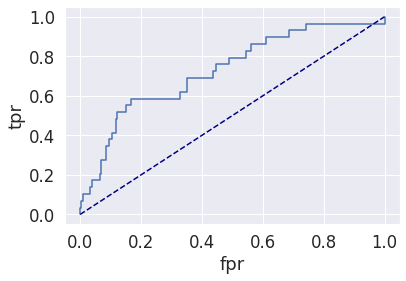

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_val_all, np.array(store_val_probs).ravel())
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('fpr')
plt.ylabel('tpr')
np.save('roc_dnn_test.npy',np.array([fpr, tpr]))

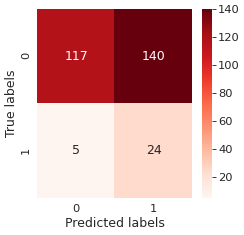

In [ ]:
idx_thr = np.where(tpr>=0.8)[0][0]
prob_thr = thresholds[idx_thr]
y_predicted = np.zeros(y_val_all.shape[0]).reshape(-1,1)
y_predicted[np.array(store_val_probs).reshape(-1,1)>=prob_thr]=1
#print(f'validation accuracy: {np.count_nonzero(y_val_all.reshape(-1,1)==y_predicted)/len(y_val_all)}')
cm_val = confusion_matrix(y_val_all, y_predicted)
my_dpi=50
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(5, 5), dpi=my_dpi)
for i in range(1):
    #ax = axs[i]
    ax = plt.subplot()
    sns.set(font_scale=1.5)
    sns.heatmap(cm_val, annot=True,ax=ax, cmap="Reds", fmt="d")  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
plt.savefig('confusion_mat_test.jpg')